# Homework 3

The goal of this assignment was to predict the Combined Unrounded adjusted Fuel Economy using various models and trained and tested on the 2015-2018 Fuel Economy data.


### Importing Libraries and Data

In [97]:
import numpy as np
import pandas as pd
import sklearn
import fancyimpute
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("hw3data.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (15,51,52,53,54,55,56,57,58,59,60,61,62,63,64,67,72,75,76,77,78,82,84,85,86,89,90,91,92,93,94,95,96,97,102,103,104,105,106,108) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


After reading in the data, I pruned out columns based on regular expressions I expected to be found. Aside from the columns that we were told to drop, I also dropped ones that seemed overly specific (usually descriptions of other variables) and would create way too many new features when I one-hot encoded the data.

In [3]:
data = data[data.columns.drop(list(data.filter(regex='EPA')))]
data = data[data.columns.drop(list(data.filter(regex='Guzzler')))]
data = data[data.columns.drop(list(data.filter(regex='CO2')))]
data = data[data.columns.drop(list(data.filter(regex='Smog')))]
data = data[data.columns.drop(list(data.filter(regex='Unnamed')))]
data = data[data.columns.drop(list(data.filter(regex='cost')))]
data = data[data.columns.drop(list(data.filter(regex='Range')))]
data = data[data.columns.drop(list(data.filter(regex='Rating')))]
data = data[data.columns.drop(list(data.filter(regex='GHG')))]
data = data[data.columns.drop(list(data.filter(regex='mpg')))]
data = data[data.columns.drop(list(data.filter(regex='Desc')))]
data.drop(['Carline','Division', 'Oil Viscosity'], axis=1, inplace=True)

#list(data.columns)

#### Preprocessing
Next I split between continuous columns and categorical columns which was helpful for preprocessing the categoricals.

In [4]:
data = data.dropna(thresh=len(data)/100,axis=1)
len(data.columns)
cont_cols = data.select_dtypes(exclude=['object'])
del cont_cols['Comb Unrd Adj FE - Conventional Fuel']

cat_cols = data.select_dtypes(include=['object'])


Then I split X and y train/test in order to enable one-hot encoding of categorical variables, and used get_dummies to create the new features.

In [6]:
for col in cat_cols:
    data[col] = data[col].astype('category')
    
X_train = data.loc[data['Model Year'] < 2018]
del X_train['Comb Unrd Adj FE - Conventional Fuel']
y_train = data.loc[data['Model Year'] < 2018,['Comb Unrd Adj FE - Conventional Fuel']]

X_test = data.loc[data['Model Year'] == 2018]
del X_test['Comb Unrd Adj FE - Conventional Fuel']
y_test = data.loc[data['Model Year'] == 2018,['Comb Unrd Adj FE - Conventional Fuel']]

cat_cols = list(cat_cols)


In [7]:
X_whole = pd.concat((X_train, X_test))
y_whole = pd.concat((y_train, y_test))   
X_whole = pd.get_dummies(X_whole, columns=cat_cols)

I decided to use fancyimpute because mean imputation and knn imputation didn't seem to be the right choice based on the nature of the encoded categorical variables (measuring euclidean distance didn't seem appropriate for a set of binary variables). 

Please note: I accidentally converted the following cell into markdown after i had run the imputer and I didn't want to re-do fancy impute (which takes a long time), so please believe that I did run fancyimpute even though it doesn't look like I did since there's no record of it running on Jupyter

In [ ]:
mice = fancyimpute.MICE(verbose=0)
X_fancy_mice = mice.complete(X_whole)

After imputation was complete I re-split train data (2015-2017) and test data (2018)

In [150]:
X_whole_out = pd.DataFrame(X_fancy_mice)
X_whole_out.columns = X_whole.columns
X_whole_out.index = X_whole.index
X_whole_out

X_train = X_whole_out.loc[X_whole_out['Model Year'] < 2018]
X_test = X_whole_out.loc[X_whole_out['Model Year'] == 2018]

### Task 1: Linear Model
For my linear model I chose the Ridge regression, and made a pipeline first through Standard Scaler and then through the Ridge model. Below you can see the results from this model, tuned on GridsearchCV to find the best alpha parameter.

In [25]:
ridge_pipe = make_pipeline(StandardScaler(), Ridge())
param_grid_r = {'ridge__alpha': np.logspace(-3,3,13)}
grid = GridSearchCV(ridge_pipe, param_grid_r, cv=10)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.score(X_test, y_test))


/Users/priyamedberry/scikit-learn/sklearn/model_selection/_search.py:714: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'ridge__alpha': 100.0}
0.864468553895


The R^2 for this model was 0.864, and the best alpha parameter was 100. However, the homework instructions noted that splitting the train/test data by year removes the iid assumption, so I decided to reevaluate the model on newly split train/test data, as shown below.

In [27]:
X_train_iid, X_test_iid, y_train_iid, y_test_iid = train_test_split(X_whole_out, 
                                                                    y_whole, 
                                                                    random_state=0)

print(grid.score(X_test_iid, y_test_iid))

0.917232671159


As shown above, the R^2 actually improved on the newly split data from 0.864 to 0.917, thus confirming this is a decent fit for the data.

### Task 2: Feature Engineering

In the exploration of feature engineering, I decided to look at polynomializing some of the features, such as #Cyl and #Gears. I decided against using interaction terms because that method is usually aided by knowledge of what features are likely to interact, and I will be the first to admit that my knowledge of cars is very limited and therefore I didn't feel like it would have been smart for me to guess feature interactions.

Below is my first attempt at using PolynomialFeatures. Unfortunately, this transformation doesn't allow for you to specify which features you want to transform, so instead it transformed all ~1000 of the features instead of the ~5 that I wanted to transform (I don't think it's wise to polynomialize all the one-hot encoded categorical variables). It is for this reason that I think the score drops to 0.70, as shown below.

In [29]:
poly_lr = make_pipeline(PolynomialFeatures(include_bias=False), Ridge(alpha=100))

poly_lr.fit(X_train, y_train)
poly_lr.score(X_test, y_test)

/Users/priyamedberry/scikit-learn/sklearn/linear_model/ridge.py:155: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0.69891791571520567

In order to account for the issue discussed above, I decided to use to create a new train/test set from just the continuous columns to see if the model would do better with more controlled transformation (even if it means sacrificing the categorical variables).

In [32]:
X_train_poly = X_train[list(cont_cols)]
X_test_poly = X_test[list(cont_cols)]

poly_l2 = make_pipeline(StandardScaler(), 
                        PolynomialFeatures(include_bias=False), Ridge(alpha=100))

poly_l2.fit(X_train_poly, y_train)
poly_l2.score(X_test_poly, y_test)

0.60517685184013303

Since the R^2 score dropped to 0.605, it seems that the categorical variables are more necessary than previously though, and thus it is not worth dropping them from the dataset just to making the process of creating polynomial features easier. With these results my conclusion is that unless we can pick specifically which features we want to polynomialize while still preventing data leakage (i.e. without polynomializing certain features and then concatenating them with the rest), then this method of feature engineering is not very useful on this dataset. It's also arguably not that necessary, since polynomializing is usually used when you have too few features and want more to work with. This dataset already has a lot of features, and therefore doesn't seem to need more.

### Task 3 Any Models
After looking at the X dataset again, I realized that it was one-hot encoding release date, which is very specific and arguably unnecessary with the 'Model Year' in the dataset, so I decided to remove it.

In [158]:
y_train = data.loc[data['Model Year'] < 2018,['Comb Unrd Adj FE - Conventional Fuel']]
y_test = data.loc[data['Model Year'] == 2018,['Comb Unrd Adj FE - Conventional Fuel']]
X_train = X_train[X_train.columns.drop(list(X_train.filter(regex='Release')))]
X_test = X_test[X_test.columns.drop(list(X_test.filter(regex='Release')))]


I decided to use the Random Forest Regressor because it allows for ease of analysis of feature importances. Below is my initial fitting and testing of the 2015-2017 and 2018 data.

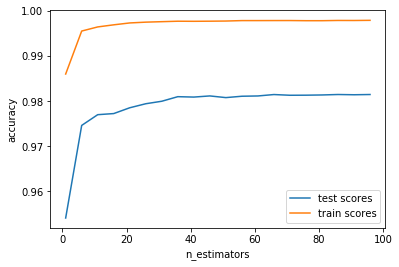

In [126]:
import warnings
warnings.filterwarnings('ignore')

train_scores = []
test_scores = []

rf = RandomForestRegressor(warm_start=True)
estimator_range = range(1, 100, 5)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    
plt.plot(estimator_range, test_scores, label="test scores")
plt.plot(estimator_range, train_scores, label="train scores")
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

As shown in the plot above, the Random Forest Regressor works very well on this dataset, as it seems to plateau at ~0.98. Next I wanted to look at the feature range to see if there's a point where the performance plateaus and more features aren't as helpful.

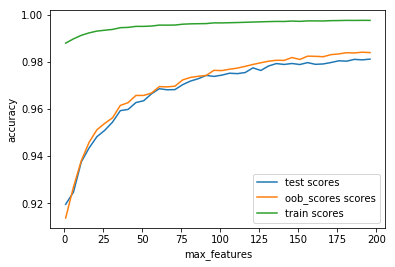

In [127]:
train_scores = []
test_scores = []
oob_scores = []

feature_range = range(1, 200, 5)
for max_features in feature_range:
    rf = RandomForestRegressor(max_features=max_features, oob_score=True,
                               n_estimators=200, random_state=0)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)
    
plt.plot(feature_range, test_scores, label="test scores")
plt.plot(feature_range, oob_scores, label="oob_scores scores")
plt.plot(feature_range, train_scores, label="train scores")
plt.legend()
plt.ylabel("accuracy")
plt.xlabel("max_features")
plt.show()

The Random Forest Regressor seems to start plateauing after 100 features, but still increases. Next I re-fit and test the model on the randomly split dataset (in order to evaluate on the iid assumption). The scores are shown in the plot below. The model seems to work as well on the iid data.

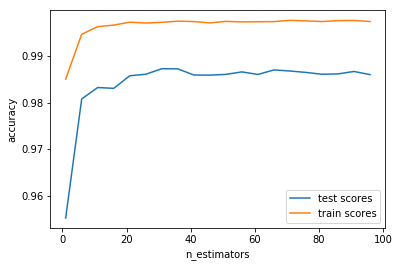

In [125]:
import warnings
warnings.filterwarnings('ignore')

train_scores = []
test_scores = []

rf = RandomForestRegressor(warm_start=True)
estimator_range = range(1, 100, 5)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train_iid, y_train_iid)
    train_scores.append(rf.score(X_train_iid, y_train_iid))
    test_scores.append(rf.score(X_test_iid, y_test_iid))
    
plt.plot(estimator_range, test_scores, label="test scores")
plt.plot(estimator_range, train_scores, label="train scores")
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

Based on the information I learned above, I'm going to stick with the Random Forest model for my feature selection.

### Task 4: Feature Selection
Below I wanted to get a look how well the model performs on the top 25 features in the dataset.

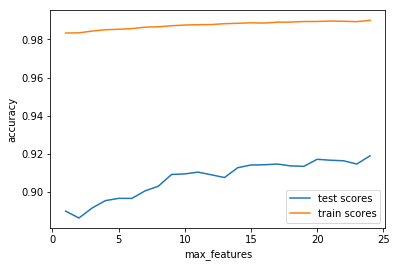

In [159]:
train_scores = []
test_scores = []

feature_range = range(1, 25, 1)
for max_features in feature_range:
    rf = RandomForestRegressor(max_features=max_features, 
                               n_estimators=200, random_state=0)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    
plt.plot(feature_range, test_scores, label="test scores")
plt.plot(feature_range, train_scores, label="train scores")
plt.legend()
plt.ylabel("accuracy")
plt.xlabel("max_features")
plt.show()

0.92 is a decent score, and with this information let's look at the feature importances in the plot below

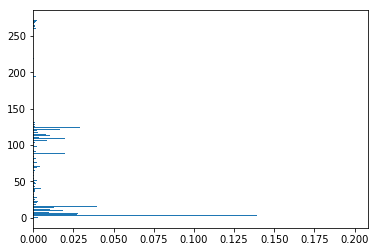

In [160]:
rf.feature_importances_

plt.barh(range(len(rf.feature_importances_)), rf.feature_importances_)
plt.show()

In [161]:
important_features_dict = {}
for x,i in enumerate(rf.feature_importances_):
    important_features_dict[x]=i


important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print ('Most important features: %s' %important_features_list)

Most important features: [2, 3, 9, 119, 15, 1, 124, 6, 4, 109, 88, 10, 121, 14, 8, 85, 11, 12, 113, 7, 5, 106, 112, 114, 13, 104, 118, 111, 107, 40, 70, 90, 110, 52, 0, 117, 262, 22, 45, 271, 49, 76, 20, 96, 69, 21, 28, 266, 51, 98, 120, 16, 47, 81, 194, 101, 19, 34, 100, 18, 63, 86, 260, 68, 270, 91, 71, 46, 263, 103, 37, 41, 264, 25, 60, 125, 56, 43, 268, 48, 23, 128, 131, 39, 36, 53, 265, 123, 130, 65, 31, 108, 78, 261, 219, 24, 92, 54, 97, 58, 77, 32, 79, 126, 62, 44, 29, 80, 267, 269, 145, 75, 42, 122, 72, 74, 84, 157, 240, 67, 38, 99, 226, 159, 105, 102, 146, 183, 82, 186, 30, 201, 129, 59, 224, 182, 61, 173, 127, 95, 188, 178, 225, 115, 66, 33, 93, 197, 132, 156, 217, 257, 153, 198, 218, 151, 203, 185, 235, 253, 164, 174, 213, 180, 214, 191, 244, 57, 172, 116, 195, 233, 133, 167, 258, 147, 35, 256, 171, 184, 210, 83, 144, 223, 138, 50, 142, 177, 143, 161, 170, 231, 94, 136, 204, 248, 245, 141, 135, 243, 150, 175, 176, 230, 215, 228, 166, 238, 229, 139, 206, 220, 227, 152, 149, 2

The 10 most important features are sorted in the array above, and their corresponding column names are shown in the array below:

In [162]:
list(X_train.iloc[:,[2,3,9,119,15,1,124,6,4,109]])

['Eng Displ',
 '# Cyl',
 '4Dr Pass Vol',
 'Drive Sys_F',
 'Carline Class',
 'Index (Model Type Index)',
 'Car/Truck Category - Cash for Clunkers Bill._car',
 'Max Biodiesel %',
 '# Gears',
 'Trans_CVT']

These features are the most necessary to our model based on all the plots/analysis shown above. If we include just these features, the model behaves as follows:

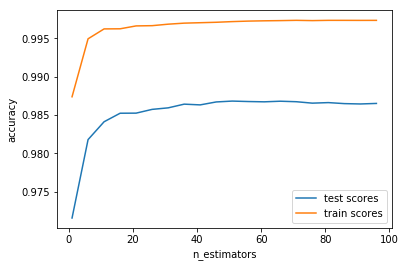

In [164]:
import warnings
warnings.filterwarnings('ignore')

new_X_train_iid = X_train_iid.iloc[:,[2,3,9,119,15,1,124,6,4,109]]
new_X_test_iid = X_test_iid.iloc[:,[2,3,9,119,15,1,124,6,4,109]]

train_scores = []
test_scores = []

rf = RandomForestRegressor(warm_start=True)
estimator_range = range(1, 100, 5)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train_iid, y_train_iid)
    train_scores.append(rf.score(X_train_iid, y_train_iid))
    test_scores.append(rf.score(X_test_iid, y_test_iid))
    
plt.plot(estimator_range, test_scores, label="test scores")
plt.plot(estimator_range, train_scores, label="train scores")
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

As shown above, the data performs very well (arguably slightly better than before) with just those 10 features, which leads me to believe all the other features can be excluded from the dataset. Thus I would conclude that the best/most important features are: 'Eng Displ', '# Cyl', '4Dr Pass Vol', 'Drive Sys_F', 'Carline Class', 'Index (Model Type Index)', 'Car/Truck Category - Cash for Clunkers Bill.car','Max Biodiesel %','# Gears', 'Trans_CVT'. I looked up the most important factors in determining fuel economy and while it didn't mention all the features listed above, it did say number of gears and cylinders is important, which I think is a decent validation that this analysis is correct.